<a href="https://colab.research.google.com/github/briangasca/Models/blob/main/KERAS_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#Keras Libraries
from keras.models import *
from keras.layers import *
from keras.layers import Dense
import math

#Importing csv file and splicing the data so our model only trains off of "Open" and "High"
# ':' skips 'Data' header and '1:2' goes to the 'Open' and 'High' columns.
tsla = pd.read_csv("TSLA.csv")
data_target = tsla.filter(['High'])
target = data_target.values
train_data_len = math.ceil(len(tsla) * .80)


In [99]:
#MinMax scaler that makes values between 0 and 1. We use this on training data
sc = MinMaxScaler(feature_range=(0,1))
training_data_scaled = sc.fit_transform(target)

#We will now make 3D arrays to feed to the model.
train_data = training_data_scaled[0:train_data_len, : ]

x_train = []
y_train = []

#60 timesteps in for loop. We then convert x_train to a 3D array and make 60 timestamps, one feature at each step.
for i in range(180, len(train_data)):
  x_train.append(train_data[i-180:i, 0])
  y_train.append(train_data[i,0])
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [100]:
#Setting up our neural network & Adding layers
model = Sequential()

#Add data to the model with LSTM (Long Short Term Memory).
# 50 units is the dimensionality of the output space, return_sequences=True is set to True because it's necessary for stacking LSTM layers so the output is ALSO a 3D array
# input_shape is just the shape of the training set, so the same set we used in the cell above for x_train.
# 4-Layer Neural Network
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))
#The Dense layer will take input from every neuron in the previous layer and output to every neuron in the next layer. Essentially the output layer.
model.add(Dense(units=1))

#Adam Optimization is a solid neural network algorithm that Keras has. We are also calculating the loss using mean squared error to see how good the model is performing. Lower == Better!!
model.compile(optimizer='adam', loss='mean_squared_error')

#Training the actual model. Inputting x_train (3D array), y_train (1D array), it will run for 100 epochs (basically just 100 times.), batch_size means the number of samples of data that is going to be given per epoch.
#So there is around 2200 different points of data in train_data, so 2200 / 32 =~ 64, therefore for each epoch run, 64 little files will be run through the model.
model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
74/74 [==============================] - 10s 28ms/step - loss: 2.7572e-04
Epoch 2/100
74/74 [==============================] - 2s 26ms/step - loss: 1.0237e-04
Epoch 3/100
74/74 [==============================] - 2s 26ms/step - loss: 9.4481e-05
Epoch 4/100
74/74 [==============================] - 2s 25ms/step - loss: 8.7662e-05
Epoch 5/100
74/74 [==============================] - 2s 26ms/step - loss: 7.7542e-05
Epoch 6/100
74/74 [==============================] - 2s 33ms/step - loss: 7.6093e-05
Epoch 7/100
74/74 [==============================] - 2s 25ms/step - loss: 8.0774e-05
Epoch 8/100
74/74 [==============================] - 2s 25ms/step - loss: 6.7100e-05
Epoch 9/100
74/74 [==============================] - 2s 26ms/step - loss: 7.0390e-05
Epoch 10/100
74/74 [==============================] - 2s 26ms/step - loss: 4.9850e-05
Epoch 11/100
74/74 [==============================] - 2s 26ms/step - loss: 5.6303e-05
Epoch 12/100
74/74 [==============================] - 2s 33ms/

In [101]:
# model.save('/model.keras')
test_data = training_data_scaled[train_data_len - 180:,:]

In [102]:
x_test = []
y_test = target[train_data_len:,:]

#For i in range from 60 (timstep ) to 321 (60 + length of the dataset using dataset_test.shape)
for i in range(180, len(test_data)):
  x_test.append(test_data[i-180:i,0])

#make x_test into a numpy array
x_test = np.array(x_test)
#Reshape x_test to a 3D array for Keras to go through
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Keras Prediction
predicted_stock_price = model.predict(x_test)

#Change back to numerical values instead of values between 0-1 so that we can display it well on graph.
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

20/20 [==============================] - 2s 17ms/step


<ipython-input-112-2f3c9585066b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_stock_price


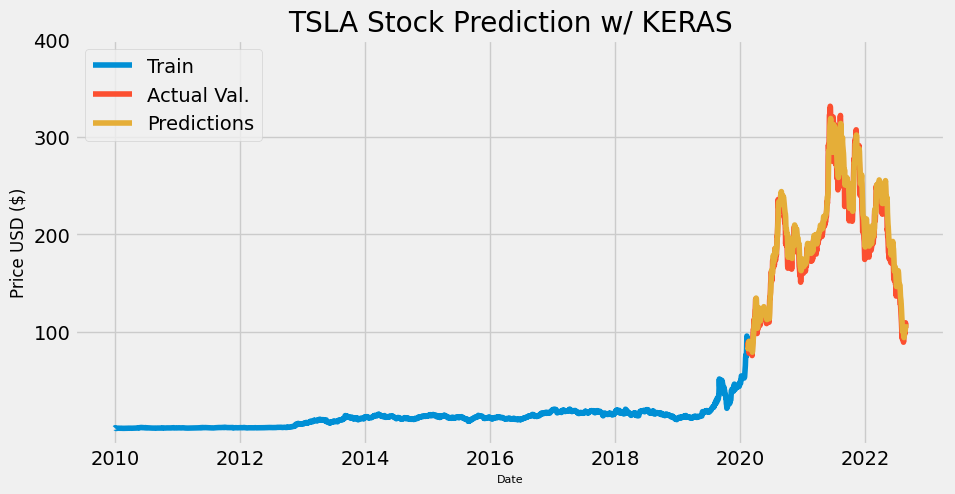

In [112]:
#Plotting

train = data_target[:train_data_len]
valid = data_target[train_data_len:]
valid['Predictions'] = predicted_stock_price

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
plt.title('TSLA Stock Prediction w/ KERAS')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Price USD ($)', fontsize=12)

plt.plot(train['High'])
plt.plot(valid[['High','Predictions']])

#Every 75 indicdes in dataset_test, pick a date and make it a tick on the x-axis
plt.xticks([0, 500, 1000,1500,2000,2500,3000], ['2010', '2012', '2014', '2016', '2018', '2020', '2022'])
plt.yticks([125,250,375,500], ['100','200','300','400'])

plt.legend(['Train','Actual Val.','Predictions'], loc='upper left')
plt.show()